# import site-package

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

# Class Dataset

In [ ]:
class CarRacingDataset(Dataset):
    def __init__(self, npy_file):
        self.data = np.load(npy_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = torch.tensor(sample, dtype=torch.float32)
        return sample

# Class AE

### Encoder

In [ ]:
class AEEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        z = self.fc2(torch.relu(self.fc1(x)))
        return z

### Decoder

In [ ]:
class AEDecoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.sigmoid( self.fc2( torch.relu(self.fc1(x)) ) )
        return x

### VAE Module

In [ ]:
class AE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()
        self.encoder = AEEncoder(input_size, hidden_size, latent_size)
        self.decoder = AEDecoder(latent_size, hidden_size, input_size)

    def forward(self, x):
        z = self.encoder(x)
        reconstruct = self.decoder(z)
        return reconstruct, z

# Test Model

### Load Dataset

In [ ]:
dataset = CarRacingDataset("/content/drive/MyDrive/VAE/data/car_racing_states.npy")
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
for i in dataloader:
    print(i.shape)
    break

torch.Size([64, 72, 72])


### Initialize

In [ ]:
input_size = 72 * 72
hidden_size = 800
latent_size = 64
model_nums = 10700

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = AE(input_size, hidden_size, latent_size).to(device)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/AE/model/0~1/model(latent=50)/model_{model_nums}.pth'))
model.eval()

### Test

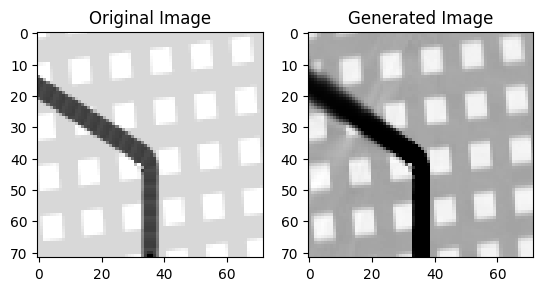

In [ ]:
sample_image = dataset[0]
sample_image = sample_image.view(-1, input_size).to(device)
mean, log_var = model.encoder(sample_image)
generated_image = model.decoder(mean).view(72,72)

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(sample_image.view(72, 72), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Generated Image')
plt.imshow(generated_image.detach().numpy(), cmap='gray')
plt.show()

### Generate Picture

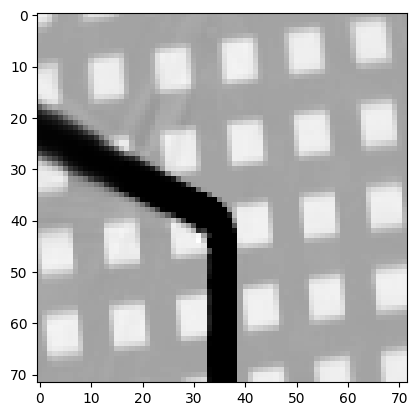

In [ ]:
# 這不重要，這是無中生有
with torch.no_grad():
    z = torch.randn(1, latent_size)
    image = model.decoder(z).view(72, 72)
    image = image.detach().numpy()
    plt.imshow(image, cmap="gray")
    plt.show()